<a href="https://colab.research.google.com/github/leowu4ever/PhD_Note/blob/master/experiments_breathing_signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Housekeeping**

List all files on google drive

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

import librosa
import librosa.display

import numpy as np
from pathlib import Path

import IPython

import scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

!pip install pyhht
import pyhht

import pywt

from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.insert(0,'/content/gdrive/My Drive/colab BET')

In [0]:
path_gdrive = '/content/gdrive/My Drive/colab BET/'
path_gdrive_clips = path_gdrive + 'clips/'
path_gdrive_plots = path_gdrive + 'plots/'
path_gdrive_train_audio = path_gdrive + 'train_audio/'
path_gdrive_train_audio_in = path_gdrive_train_audio + 'in/'
path_gdrive_train_audio_out = path_gdrive_train_audio + 'out/'

path_gdrive_train_img = path_gdrive + 'train_img/'
path_gdrive_train_img_in = path_gdrive_train_img + 'in/'
path_gdrive_train_img_out = path_gdrive_train_img + 'out/'

path_gdrive_valid_img = path_gdrive + 'valid_img/'
path_gdrive_valid_img_in = path_gdrive_valid_img + 'in/'
path_gdrive_valid_img_out = path_gdrive_valid_img + 'out/'

file_names = [path_gdrive_clips + 'My memos 7.wav', path_gdrive_clips + 'My memos 8.wav', path_gdrive_clips + 'My memos 9.wav', path_gdrive_clips + 'My memos 10.wav'];
file_count = len(file_names)

def create_paths(file_names):
  clips = []
  rates = []
  for file_name in file_names:
    clip_path = Path(file_name)
    clip, rate = librosa.load(clip_path)
    
    clips.append(clip)
    rates.append(rate)

  return clips, rates

clips, rates = create_paths(file_names)
sr = rates[0]

In [0]:
xlines_breathing_in = np.array([
    [0.6, 5.5, 6.9, 9, 10.5, 12.8, 14.3, 16.8, 18.8, 20.3, 23],
    [0.3, 3.5, 5.7, 8.2, 10.3, 11.8, 14.4, 17.3, 19.1, 20.9, 22.5, 24.6, 26.5, 28.4, 30.7, 32.9, 34.9, 37, 39.2, 41, 42.2],
    [3.8, 5.7, 8.1, 11.4, 14, 16.6, 19.3, 23, 26.9, 30.7],
    [5.5, 7.7, 10.1, 12.1, 14.3, 16.8, 27, 45, 56.5]
])

xlines_breathing_out = np.array([
    [2.7, 6.3, 8, 9.8, 11.6, 13.3, 15.3, 17.8, 19.7, 21.3],
    [1.6, 4.2, 6.6, 9.3, 11, 13.1, 15.9, 18.4, 20.1, 21.7, 23.6, 25.4, 27.5, 29.4, 31.7, 34, 36.1, 38, 39.8, 41.7, 43.2],
    [4.2, 6.8, 9.4, 12.7, 15.5, 17.8, 20.6, 25.2, 27.9, 33.4],
    [6.5, 8.7, 11.4, 13.2, 15.3, 17.5, 20.8, 23.6, 28.3, 33.4, 44, 46.6, 57.3]
])

In [0]:
segmentation_size = 1*sr
overlapping_perc = 0.25
imf_iteration_limit = 100

# **Plotting functions**

In [0]:
def display_fft(clips):
  for clip in clips:
    fft = scipy.fftpack.fft(clip)
    num_of_samples = len(clip)
    fft_freq = scipy.fftpack.fftfreq(num_of_samples, 1/sr)
    plt.figure(figsize=(20,4))
    plt.xlim(0,6000)
    plt.plot(fft_freq[0:int(num_of_samples/2)], (abs(fft)/num_of_samples)[0:int(num_of_samples/2)])

In [0]:
def display_audio_files(file_names):
  for file_name in file_names:
    print(file_name)
    IPython.display.display(IPython.display.Audio(file_name))

In [0]:
def display_audio_waveform(clips):
  for clip in clips:
    plt.figure(figsize=(20,4))
    librosa.display.waveplot(clip)

In [0]:
def display_stft_spectrograms(clips, breathing_in_displayed=False, breathing_out_displayed=False, title=None, spectrogram_width=20, spectrogram_height=4):
  i = 0
  fig, ax = plt.subplots(1, file_count, figsize=(spectrogram_width,spectrogram_height))

  for j in range(len(clips)):
    clip_stft = librosa.stft(clips[j], window='hamm')
    clip_stft_mag, clip_stft_phase = librosa.magphase(clip_stft)
    clip_stft_mag_db = librosa.amplitude_to_db(clip_stft_mag, ref=np.max)
    
    if(file_count == 1):
      librosa.display.specshow(clip_stft_mag_db, x_axis='time', y_axis='linear', ax=ax)

      ax.set_title(title + file_names[i] + " --- yellow line for breathing in, red line for breathing out")
      
      if(breathing_in_displayed):
        for xline_breathing_in in xlines_breathing_in[j]:
          ax.axvline(xline_breathing_in, c='y')
      
      if(breathing_out_displayed):
        for xline_breathing_out in xlines_breathing_out[j]:
          ax.axvline(xline_breathing_out, c='r') 
        
    else:
      librosa.display.specshow(clip_stft_mag_db, x_axis='time', y_axis='linear', ax=ax[i])
      
      ax[i].set_title(title + file_names[i] + " --- yellow line for breathing in, red line for breathing out")
    
      if(breathing_in_displayed):
        for xline_breathing_in in xlines_breathing_in[j]:
          ax[i].axvline(xline_breathing_in, c='y')
      
      if(breathing_out_displayed):
        for xline_breathing_out in xlines_breathing_out[j]:
          ax[i].axvline(xline_breathing_out, c='r') 
        
    i=i+1

In [0]:
def display_mel_spectrograms(clips, breathing_in_displayed=False, breathing_out_displayed=False, title=None, spectrogram_width=20, spectrogram_height=4):
  i = 0
  fig, ax = plt.subplots(1,file_count, figsize=(spectrogram_width,spectrogram_height))
  
  for j in range(len(clips)):
    clip_mel_spec = librosa.feature.melspectrogram(clips[j])
    clip_mel_spec_db = librosa.amplitude_to_db(clip_mel_spec, ref=np.max)
    
    if(file_count == 1):
      librosa.display.specshow(clip_mel_spec_db, x_axis='time', y_axis='mel', ax=ax)
      
      ax.set_title(title + file_names[i] + " --- yellow line for breathing in, red line for breathing out")

      if(breathing_in_displayed):
        for xline_breathing_in in xlines_breathing_in[j]:
          ax.axvline(xline_breathing_in, c='y')
      
      if(breathing_out_displayed):
        for xline_breathing_out in xlines_breathing_out[j]:
          ax.axvline(xline_breathing_out, c='r') 
        
    else:
      librosa.display.specshow(clip_mel_spec_db, x_axis='time', y_axis='linear', ax=ax[i])
      
      ax[i].set_title(title + file_names[i] + " --- yellow line for breathing in, red line for breathing out")
      
      if(breathing_in_displayed):
        for xline_breathing_in in xlines_breathing_in[j]:
          ax[i].axvline(xline_breathing_in, c='y')
      
      if(breathing_out_displayed):
        for xline_breathing_out in xlines_breathing_out[j]:
          ax[i].axvline(xline_breathing_out, c='r') 
          
    i = i+1

# **Pre-processing**

In [0]:
def bandpass_filter(clips, low_frequency=50, high_frequency=4000, order=6):
  bandpass_filtered_clips = []
  
  for clip in clips:
    
    b,a=scipy.signal.butter(N=order, Wn=[2*low_frequency/sr, 2*high_frequency/sr], btype='band')
    x = scipy.signal.lfilter(b,a,clip)
    
    bandpass_filtered_clips.append(np.array(x))
  return bandpass_filtered_clips

In [0]:
def pre_emphasize(clips):
  pre_emphasized_clips = []
  
  for clip in clips:
    pre_emphasized_clip = []
    
    for i in range(1, len(clip)-1):
      pre_emphasized_sample = clip[i] - 0.96*clip[i-1]
      pre_emphasized_clip.append(pre_emphasized_sample)
      
    pre_emphasized_clips.append(np.array(pre_emphasized_clip))
    
  return pre_emphasized_clips

In [0]:
def normalise(clips):
  normalised_clips = []
  
  for clip in clips:   
    normalised_clip = librosa.util.normalize(clip)
    normalised_clips.append(normalised_clip)
    
  return normalised_clips   

In [0]:
# could try segmentation size of 256 and 600
def segment(clips, segmentation_size=256, overlapping_perc=0.25):
  
  segmented_clips = []
  for clip in clips:
    
    segmented_clip = []
    
    for i in np.arange(0, len(clip), int(segmentation_size*(1-overlapping_perc))):
        
        segmentation_start_point = i
        segmentation_end_point = segmentation_start_point + segmentation_size
        
        if(segmentation_end_point > len(clip)-1):
          
          extra_zeros = np.zeros((segmentation_end_point-len(clip))+1) 
          segmentation_end_point = len(clip)-1
          
        segmented_clip.append(np.array(clip[segmentation_start_point:segmentation_end_point]))
        
        if(segmentation_end_point == len(clip)-1):
          segmented_clip[-1] = np.append(segmented_clip[-1], extra_zeros)
          
    segmented_clips.append(segmented_clip) 
  return segmented_clips

In [0]:
def hamming_window(clips):
  
  hamming_windowed_clips = []
  for clip in clips:
    
    hamming_windowed_clip = []
    for segmentation in clip:
      len_hamming_window = len(segmentation)
      hamming_window = np.hamming(len_hamming_window)
      segmentation = segmentation * hamming_window
      
      hamming_windowed_clip.append(segmentation)
      
    hamming_windowed_clips.append(np.array(hamming_windowed_clip))
  return hamming_windowed_clips    

In [0]:
def hilbert_transform(clips, emd_enabled=False, amplitude_envelope_returned=True, instantaneous_frequency_returned=False):
  hilbert_transformed_clips = []
  
  for clip in clips:
    
    if(emd_enabled):
      emd = pyhht.emd.EMD(clip, fixe=imf_iteration_limit)
      imfs = emd.decompose()
      #need to rework when having multiple imfs
      hilbert_tranformed_clip = hilbert_transform_with_zero_padding(imfs[0], amplitude_envelope_returned, instantaneous_frequency_returned)
    else:
      hilbert_tranformed_clip = hilbert_transform_with_zero_padding(clip, amplitude_envelope_returned, instantaneous_frequency_returned)
    hilbert_transformed_clips.append(hilbert_tranformed_clip)

  return hilbert_transformed_clips

In [0]:
def hilbert_transform_with_zero_padding(signal, amplitude_envelope_returned=True, instantaneous_frequency_returned=False):
  padding = np.zeros(int(2 ** np.ceil(np.log2(len(signal)))) - len(signal))
  tohilbert = np.hstack((signal, padding))

  analytic_signal = scipy.signal.hilbert(tohilbert)

  analytic_signal = analytic_signal[0:len(signal)]
  amplitude_envelope = np.abs(analytic_signal)
  instantaneous_phase = np.unwrap(np.angle(analytic_signal))
  instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * sr)

  if(amplitude_envelope_returned):
    return amplitude_envelope
  
  if(instantaneous_frequency_returned):
    return instantaneous_frequency

# **Audio feature extraction**

Energy

In [0]:
def get_segmentation_short_time_energy(clips):
  clips_energy = []
  for clip in clips:
   
    clip_energy = []
    for segmentation in clip:
      energy = np.sum(np.square(segmentation))
      clip_energy.append(energy)
    
    normalized_clip_energy = clip_energy
    clips_energy.append(np.array(normalized_clip_energy))
  return clips_energy

Spectral bandwidth

In [0]:
def get_segmentation_spectral_bandwidth(segmented_clips, plots_displayed=False):
  clips_spectral_bandwidth = []
  for clip in segmented_clips:
    
    clip_spectral_bandwidth = []
    for segmentation in clip:
      spectral_bandwidth = librosa.feature.spectral_bandwidth(segmentation, sr)
      clip_spectral_bandwidth.append(spectral_bandwidth)
    
    clips_spectral_bandwidth.append(np.array(clip_spectral_bandwidth))
  return clips_spectral_bandwidth

Spectral rolloff

In [0]:
def get_segmentation_spectral_rolloff(segmented_clips, plots_displayed=False):
  clips_spectral_rolloff = []
  for clip in segmented_clips:
    
    clip_spectral_rolloff = []
    for segmentation in clip:
      spectral_rolloff = librosa.feature.spectral_rolloff(segmentation, sr)
      clip_spectral_rolloff.append(spectral_rolloff)
    
    clips_spectral_rolloff.append(np.array(clip_spectral_rolloff))
  return clips_spectral_rolloff

Spectral centroid

In [0]:
def get_segmentation_spectral_centroid(segmented_clips, plots_displayed=False):
  clips_spectral_centroid = []
  for clip in segmented_clips:
    
    clip_spectral_centroid = []
    for segmentation in clip:
      spectral_centroid = librosa.feature.spectral_centroid(segmentation, sr)
      clip_spectral_centroid.append(spectral_centroid)
    
    clips_spectral_centroid.append(np.array(clip_spectral_centroid))
  return clips_spectral_centroid

Spectral contrast

In [0]:
def get_segmentation_spectral_contrast(segmented_clips, plots_displayed=False):
  clips_spectral_contrast = []
  for clip in segmented_clips:
    
    clip_spectral_contrast = []
    for segmentation in clip:
      spectral_contrast = librosa.feature.spectral_contrast(segmentation, sr)
      clip_spectral_contrast.append(spectral_contrast)
    
    clips_spectral_contrast.append(np.array(clip_spectral_contrast))
  return clips_spectral_contrast

Spectral flatness

In [0]:
def get_segmentation_spectral_flatness(segmented_clips, plots_displayed=False):
  clips_spectral_flatness = []
  for clip in segmented_clips:
    
    clip_spectral_flatness = []
    for segmentation in clip:
      spectral_flatness = librosa.feature.spectral_flatness(segmentation)
      clip_spectral_flatness.append(spectral_flatness)
    
    clips_spectral_flatness.append(np.array(clip_spectral_flatness))
  return clips_spectral_flatness

MFCC

In [0]:
def get_segmentation_mfcc(segmented_clips, plots_displayed=False):
  clips_mfcc = []
  for clip in segmented_clips:
    
    clip_mfcc = []
    for segmentation in clip:
      mfcc = librosa.feature.mfcc(segmentation, sr)
      clip_mfcc.append(mfcc)
      
    clips_mfcc.append(np.array(clip_mfcc))  
  return clips_mfcc

MFCC delta

In [0]:
def get_segmentation_mfcc_delta(segmented_clips, mode='nearest', plots_displayed=False):
  clips_mfcc_delta = []
  for clip in segmented_clips:
    
    clip_mfcc_delta = []
    for segmentation in clip:
      mfcc = librosa.feature.mfcc(segmentation, sr)
      mfcc_delta = librosa.feature.delta(mfcc, mode=mode)
      clip_mfcc_delta.append(mfcc_delta)
      
    clips_mfcc_delta.append(np.array(clip_mfcc_delta))  
  return clips_mfcc_delta

MFCC delta delta

In [0]:
def get_segmentation_mfcc_delta_delta(segmented_clips, mode='nearest', plots_displayed=False):
  clips_mfcc_delta_delta = []
  for clip in segmented_clips:
    
    clip_mfcc_delta_delta = []
    for segmentation in clip:
      mfcc = librosa.feature.mfcc(segmentation, sr)
      mfcc_delta_delta = librosa.feature.delta(mfcc, mode=mode, order=2)
      clip_mfcc_delta_delta.append(mfcc_delta_delta)
      
    clips_mfcc_delta_delta.append(np.array(clip_mfcc_delta_delta))  
  return clips_mfcc_delta_delta

Silent ratio (silent frame/total frame)

Normalise all of the features on the training set

# **Statistic feature extraction**

In [0]:
def energy_filter(segmented_clips, clips_energy, energy_threshold=0.2):
  clips_energy_positions_filtered = []
  for clip_energy in clips_energy:
    clips_energy_positions_filtered.append(np.asarray(np.where(clip_energy >= energy_threshold))[0])
  
  
  segmented_clips_filtered = []
  for i in range(len(segmented_clips)):
    segmented_clip_filtered = []
    for position in clips_energy_positions_filtered[i]:
      segmented_clip_filtered.append(np.array(segmented_clips[i][position]))
    segmented_clips_filtered.append(np.array(segmented_clip_filtered))

  clips_energy_filtered = []
  for i in range(len(clips_energy)):
    clip_energy_filtered = []
    for position in clips_energy_positions_filtered[i]:
      clip_energy_filtered.append(np.array(clips_energy[i][position]))
    clips_energy_filtered.append(np.array(clip_energy_filtered))
  
  return segmented_clips_filtered, clips_energy_filtered, clips_energy_positions_filtered

In [0]:
def get_feature_mean(segmented_clips_feature):
  segmented_clips_feature_mean = []
  for segmented_clip_feature in segmented_clips_feature:
    
    segmented_clip_feature_mean = []
    for segmentation_feature in segmented_clip_feature:
      mean_feature = np.mean(segmentation_feature)
      segmented_clip_feature_mean.append(np.array(mean_feature))
    
    segmented_clips_feature_mean.append(np.array(segmented_clip_feature_mean))
  return segmented_clips_feature_mean

In [0]:
def get_feature_std(segmented_clips_feature):
  segmented_clips_feature_std = []
  for segmented_clip_feature in segmented_clips_feature:
    
    segmented_clip_feature_std = []
    for segmentation_feature in segmented_clip_feature:
      std_feature = np.std(segmentation_feature)
      segmented_clip_feature_std.append(np.array(std_feature))
    
    segmented_clips_feature_std.append(np.array(segmented_clip_feature_std))
  return segmented_clips_feature_std

# Completed pipelines

In [0]:
bandpass_filtered_clips = bandpass_filter(clips)
pre_emphasized_clips = pre_emphasize(bandpass_filtered_clips)

hilbert_transformed_clips = hilbert_transform(clips, emd_enabled=False, amplitude_envelope_returned=True, instantaneous_frequency_returned=False)
normalised_clips = normalise(hilbert_transformed_clips)
segmented_clips = segment(normalised_clips, segmentation_size, overlapping_perc)
hamming_windowed_clips = hamming_window(segmented_clips)

#filter voiced/non-voiced segmentation with time-series energy
clips_energy = get_segmentation_short_time_energy(hamming_windowed_clips)
segmented_clips_filtered_with_energy, _, _ = energy_filter(segmented_clips, clips_energy, 0.2)

In [0]:
segmented_clips_spectral_bandwidth = get_segmentation_spectral_bandwidth(segmented_clips_filtered_with_energy)
segmented_clips_spectral_rolloff = get_segmentation_spectral_rolloff(segmented_clips_filtered_with_energy)
segmented_clips_spectral_centroid = get_segmentation_spectral_centroid(segmented_clips_filtered_with_energy)
segmented_clips_spectral_contrast = get_segmentation_spectral_contrast(segmented_clips_filtered_with_energy)
segmented_clips_spectral_flatness = get_segmentation_spectral_flatness(segmented_clips_filtered_with_energy)
segmented_clips_spectral_mfcc = get_segmentation_mfcc(segmented_clips_filtered_with_energy)
segmented_clips_spectral_mfcc_delta = get_segmentation_mfcc_delta(segmented_clips_filtered_with_energy)
segmented_clips_spectral_mfcc_delta_delta = get_segmentation_mfcc_delta_delta(segmented_clips_filtered_with_energy)

# **Plots for revisiting**

<Figure size 1440x360 with 0 Axes>

Text(0.5, 1.0, 'clips_energy, segmentation that satisfy: 20')

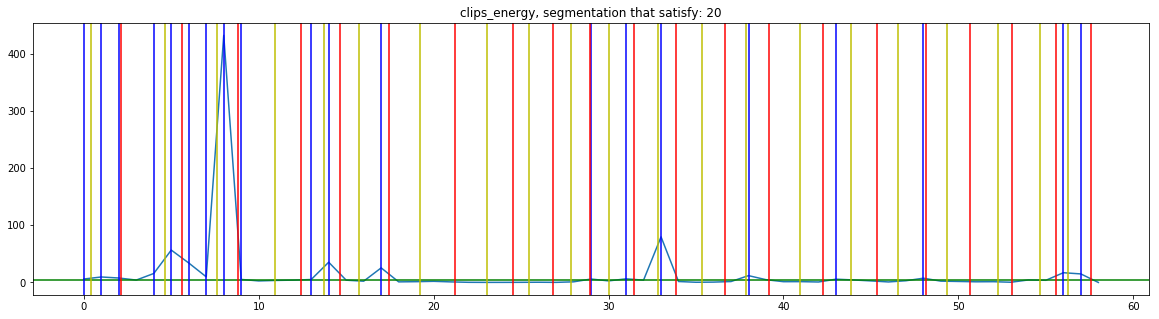

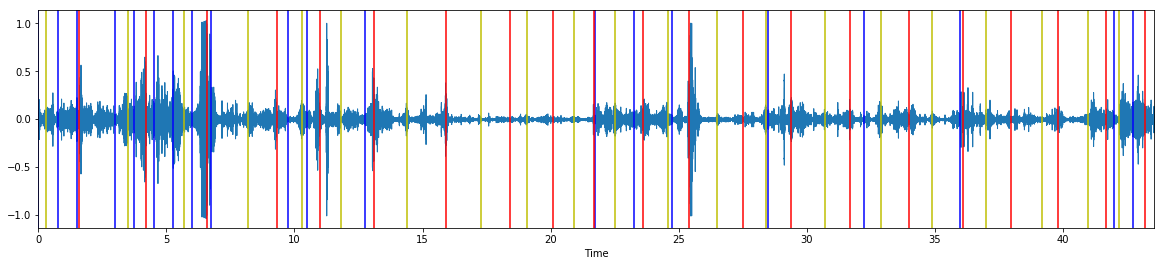

In [0]:
#@title Default title text { run: "auto" }
run_stft_plots = True #@param {type:"boolean"}


energy_threshold = 5 #@param {type:"number"}
clip_num = 1 #@param {type:"integer"}

breathing_in_displayed = True #@param {type:"boolean"}
breathing_out_displayed = True #@param {type:"boolean"}
seg_pos_larger_than_energy_threshold_displayed = True #@param {type:"boolean"}


if(run_stft_plots):
  plt.figure(figsize=(20,5))
  plt.plot(get_feature_mean(clips_energy)[clip_num])

  results = []
  for clip_energy in clips_energy:
    results.append(np.asarray(np.where(get_feature_mean(clips_energy)[clip_num] > energy_threshold)[0]))

  plt.title("clips_energy, segmentation that satisfy: " + str(len(results[0])))

  if(seg_pos_larger_than_energy_threshold_displayed):
    plt.axhline(energy_threshold, c='g')
    for r in results[clip_num]:
      plt.axvline(r, c='b')

  if breathing_out_displayed:
    for x in xlines_breathing_out[clip_num]:
      x = x / ((segmentation_size* (1-overlapping_perc)) / sr)
      plt.axvline(x, c='r')

  if breathing_in_displayed:
    for x in xlines_breathing_in[clip_num]:
      x = x / ((segmentation_size* (1-overlapping_perc)) / sr)
      plt.axvline(x, c='y')


  display_audio_waveform(np.array([clips[clip_num]]))

  if(seg_pos_larger_than_energy_threshold_displayed):
    for r in results[clip_num]:
      v_pos = r * (segmentation_size* (1-overlapping_perc)) / sr
      plt.axvline(v_pos, c='b')

  if breathing_out_displayed:
    for x in xlines_breathing_out[clip_num]:
      plt.axvline(x, c='r')

  if breathing_in_displayed:
    for x in xlines_breathing_in[clip_num]:
      plt.axvline(x, c='y')

In [0]:
#@title Display spectrogram of the signal with breathing_in and breathing_out markers { run: "auto", vertical-output: true }
run_mel_plots = False #@param {type:"boolean"}

breathing_in_displayed = False #@param {type:"boolean"}
breathing_out_displayed = True #@param {type:"boolean"}
spectrogram_width = 40 #@param {type:"integer"}
spectrogram_height = 4 #@param {type:"integer"}
plot_type = "normalised_clips" #@param ["None","clips", "filtered_clips", "pre_emphasized_clips", "normalised_clips", "all"]

if(run_mel_plots):
  filtered_clips = bandpass_filter(clips)
  pre_emphasized_clips = pre_emphasize(filtered_clips)
  normalised_clips = normalise(pre_emphasized_clips)


  if(plot_type == 'clips'):
    display_stft_spectrograms(clips, breathing_in_displayed, breathing_out_displayed, "clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(clips, breathing_in_displayed, breathing_out_displayed, "clips", spectrogram_width, spectrogram_height)

  if(plot_type == 'filtered_clips'):
    display_stft_spectrograms(filtered_clips, breathing_in_displayed, breathing_out_displayed, "filtered_clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(filtered_clips, breathing_in_displayed, breathing_out_displayed, "filtered_clips",spectrogram_width, spectrogram_height)

  if(plot_type == 'pre_emphasized_clips'):
    display_stft_spectrograms(pre_emphasized_clips, breathing_in_displayed, breathing_out_displayed, "pre_emphasized_clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(pre_emphasized_clips, breathing_in_displayed, breathing_out_displayed, "pre_emphasized_clips", spectrogram_width, spectrogram_height)

  if(plot_type == 'normalised_clips'):
    display_stft_spectrograms(normalised_clips, breathing_in_displayed, breathing_out_displayed, "normalised_clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(normalised_clips, breathing_in_displayed, breathing_out_displayed, "normalised_clips", spectrogram_width, spectrogram_height)

  if(plot_type == 'all'):
    display_stft_spectrograms(clips, breathing_in_displayed, breathing_out_displayed, "clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(clips, breathing_in_displayed, breathing_out_displayed, "clips", spectrogram_width, spectrogram_height)

    display_stft_spectrograms(filtered_clips, breathing_in_displayed, breathing_out_displayed, "filtered_clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(filtered_clips, breathing_in_displayed, breathing_out_displayed, "filtered_clips",spectrogram_width, spectrogram_height)

    display_stft_spectrograms(pre_emphasized_clips, breathing_in_displayed, breathing_out_displayed, "pre_emphasized_clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(pre_emphasized_clips, breathing_in_displayed, breathing_out_displayed, "pre_emphasized_clips", spectrogram_width, spectrogram_height)

    display_stft_spectrograms(normalised_clips, breathing_in_displayed, breathing_out_displayed, "normalised_clips", spectrogram_width, spectrogram_height)
    display_mel_spectrograms(normalised_clips, breathing_in_displayed, breathing_out_displayed, "normalised_clips", spectrogram_width, spectrogram_height)

# Testing parameters for spectrogram techniques

In [0]:
#@title test stft n_fft
run_stft_nfft = False #@param {type:"boolean"}

if(run_stft_nfft):
  power = range(5,13)
  n_ffts = np.power(2,power)
  plt.figure(figsize=(20,20))

  i = 1
  for n_fft in n_ffts:

    stft = abs(librosa.stft(normalised_clips[0], center=False, n_fft=n_fft))
    stft_mag, _ = librosa.magphase(stft)
    stft_mag_db = librosa.amplitude_to_db(stft_mag)

    plt.subplot(len(n_ffts), 1, i)
    librosa.display.specshow(stft_mag_db, cmap='magma', y_axis='log', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('n_fft' + str(n_fft))

    i=i+1

  plt.suptitle('stft of ' + file_names[0] + 'with differnt n_fft', size=20)
  plt.savefig(path_gdrive_plots+'stft_n_fft.png');

In [0]:
#@title test mel n_fft
run_mel_nfft = False #@param {type:"boolean"}

if(run_mel_nfft):

  n_ffts = np.power(2,power)
  plt.figure(figsize=(20,20))

  i = 1
  for n_fft in n_ffts:

    clip_mel_spec = librosa.feature.melspectrogram(clips[1], power=2)
    clip_mel_spec_db = librosa.amplitude_to_db(clip_mel_spec, ref=np.max)

    plt.subplot(len(n_ffts), 1, i)
    librosa.display.specshow(clip_mel_spec_db, cmap='magma', y_axis='log', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('n_fft' + str(n_fft))

    i=i+1

  plt.suptitle('mel stft of ' + file_names[0] + 'with differnt n_fft', size=20)
  plt.savefig(path_gdrive_plots+'mel_stft_n_fft.png');

In [0]:
#@title test wavelet scales
run_wavelet_scales = False #@param {type:"boolean"}

if(run_wavelet_scales):
  
  plt.figure(figsize=(20,20))
  scales_limit = 20

  for i in range(scales_limit):

    plt.subplot(scales_limit, 1, i+1)

    coef, freqs = pywt.cwt(clips[0], np.arange(1,i), 'gaus1')
    plt.imshow(coef, aspect='auto', cmap='PRGn');
    plt.colorbar()
    plt.title('scales' + str(i))

  plt.suptitle('wavelet transform' + file_names[0] + 'with different scales', size=20)
  plt.savefig(path_gdrive_plots+'wavelet_trans_scales.png');

In [0]:
#@title test wavelet funcs
run_wavelet_funs = False #@param {type:"boolean"}

if(run_wavelet_funs):
  
  plt.figure(figsize=(20,20))
  wavelets = pywt.wavelist('gaus') + pywt.wavelist('mexh') + pywt.wavelist('morl')
  i=1
  for wavelet in wavelets:

    plt.subplot(len(wavelets), 1, i)

    coef, freqs = pywt.cwt(clips[0], np.arange(1,20), wavelet)
    plt.imshow(coef, aspect='auto', cmap='PRGn');
    plt.colorbar()
    plt.title('wavelet function' + wavelet)

  #   for xline_breathing_out in xlines_breathing_out[0]:
  #     plt.axvline(xline_breathing_out*sr, c='r')

    i=i+1

  plt.suptitle('wavelet transform' + file_names[0] + 'with different wavelet functions', size=20)
  plt.savefig(path_gdrive_plots+'wavelet_trans_wav_func.png');

# Exporting

use the marker and get the first following second of samples

In [0]:
#@title Export audio files
clip_id = 3 #@param {type:"integer"}
run_export = False #@param {type:"boolean"}
file_length_sec = 1


if(run_export):
  for xline_breathing_in in xlines_breathing_in[clip_id]:
    export_file_name = str(clip_id) + '_' + str(xline_breathing_in)+'.wav'
    file_start_sample = int(xline_breathing_in*sr)
    file_end_sample = int( (xline_breathing_in+file_length_sec)*sr )
    export_file_sample = clips[clip_id][file_start_sample:file_end_sample]
    librosa.output.write_wav(path_gdrive_train_audio_in+export_file_name, export_file_sample, sr)

  for xline_breathing_out in xlines_breathing_out[clip_id]:
    export_file_name = str(clip_id) + '_' + str(xline_breathing_out)+'.wav'
    file_start_sample = int(xline_breathing_out*sr)
    file_end_sample = int( (xline_breathing_out+file_length_sec)*sr )
    export_file_sample = clips[clip_id][file_start_sample:file_end_sample]
    librosa.output.write_wav(path_gdrive_train_audio_out+export_file_name, export_file_sample, sr)

In [0]:
#@title read WAVs then generate IMGs for in and out
run_img_export = True #@param {type:"boolean"}

if(run_img_export):
  temp_in_clips = []
  temp_in_files = []

  for filename in os.listdir(path_gdrive_train_audio_in):
      if filename.endswith("wav"):
        temp_in_files.append(filename)
        temp_in_clip, temp_sr = librosa.load(path_gdrive_train_audio_in + filename)
        temp_in_clips.append(temp_in_clip)


  temp_out_clips = []
  temp_out_files = []

  for filename in os.listdir(path_gdrive_train_audio_out):
      if filename.endswith("wav"):
        temp_out_files.append(filename)
        temp_out_clip, temp_sr = librosa.load(path_gdrive_train_audio_out + filename)
        temp_out_clips.append(temp_out_clip)


  bandpass_filtered_clips = bandpass_filter(temp_in_clips)
  pre_emphasized_clips = pre_emphasize(bandpass_filtered_clips)
  hilbert_transformed_clips = hilbert_transform(pre_emphasized_clips, emd_enabled=False, amplitude_envelope_returned=True, instantaneous_frequency_returned=False)
  normalised_clips = normalise(hilbert_transformed_clips)

  for i in range(len(temp_in_clips)):

    clip_mel_spec = librosa.feature.melspectrogram(normalised_clips[i])
    clip_mel_spec_db = librosa.amplitude_to_db(clip_mel_spec, ref=np.max)

    librosa.display.specshow(clip_mel_spec_db, cmap='magma', y_axis='log', x_axis='time')
    plt.axis('off')
    plt.savefig(path_gdrive_train_img_in + temp_in_files[i].split('.wav')[0] + '.png')



  bandpass_filtered_clips = bandpass_filter(temp_out_clips)
  pre_emphasized_clips = pre_emphasize(bandpass_filtered_clips)
  hilbert_transformed_clips = hilbert_transform(pre_emphasized_clips, emd_enabled=False, amplitude_envelope_returned=True, instantaneous_frequency_returned=False)
  normalised_clips = normalise(hilbert_transformed_clips)

  for i in range(len(temp_out_clips)):

    clip_mel_spec = librosa.feature.melspectrogram(normalised_clips[i])
    clip_mel_spec_db = librosa.amplitude_to_db(clip_mel_spec, ref=np.max)

    librosa.display.specshow(clip_mel_spec_db, cmap='magma', y_axis='log', x_axis='time')
    plt.axis('off')
    plt.savefig(path_gdrive_train_img_out + temp_out_files[i].split('.wav')[0] + '.png')

# Trying fastai

In [0]:
from fastai_audio import *

import fastai
from fastai.metrics import accuracy
from fastai.torch_core import *
from fastai_audio import *

from fastai.vision import models, ClassificationInterpretation
from fastai.vision import *

In [0]:
random_seed = 8
data = ImageList.from_folder(path_gdrive_train_img).split_by_rand_pct(seed=random_seed).label_from_folder().databunch()

In [183]:
data.classes

['in', 'out']

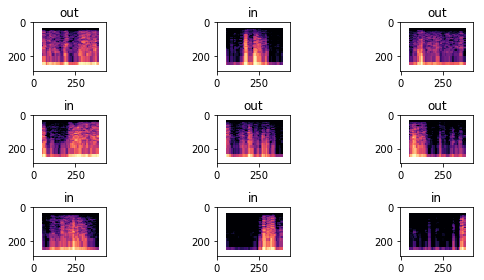

In [186]:
data.show_batch(3, figsize=(8,4), hide_axis=False)

In [192]:
learner = cnn_learner(data, models.resnet18, metrics=accuracy)
learner.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.918204,0.692606,0.571429,00:01


In [0]:
# To create some extra test data

# valid_in_files = []
# valid_out_files = []

# for filename in os.listdir(path_gdrive_valid_img_in):
#     if filename.endswith("png"):
#       valid_in_files.append(path_gdrive_valid_img_in + filename)
      
# for filename in os.listdir(path_gdrive_valid_img_out):
#     if filename.endswith("png"):
#       valid_out_files.append(path_gdrive_valid_img_out + filename)
      
# valid_in_imgs = []
# for valid_in_file in valid_in_files:
#   valid_in_imgs.append(open_image(valid_in_file))
  
# valid_out_imgs = []
# for valid_out_file in valid_out_files:
#   valid_out_imgs.append(open_image(valid_out_file))